<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/UAGD_VGG_FACE_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/Dataset2/uagd_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: uagd_dataset/train/age_70_gender_0_agedb_23619c164d94df55f713558f7949a94f_bbox_42_21_162_185.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_2b7fa81069accb1ab20196ea03dce685_bbox_42_36_184_210.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_363f553e3e0dce21b4b00b1524614d10_bbox_17_10_64_71.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_38c9991fe7e9203dbfbb677544f0def6_bbox_21_17_82_89.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_547bb6458da4e9559805e6a2d2e67156_bbox_21_11_84_95.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_6c91a1a4c3b4c9a72f68c2753d0c52aa_bbox_31_18_106_121.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_6d798400f7cf84d4ab4f97fa1eb0f2b3_bbox_40_24_108_114.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_782f6656e3062e4321325de6dfc63867_bbox_41_33_178_205.jpg  
  inflating: uagd_dataset/train/age_70_gender_0_agedb_8d23c

In [5]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return None

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [8]:
# Load and preprocess the dataset
image_dir = '/content/uagd_dataset/train'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[1])
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [9]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (7851, 224, 224, 3)
Labels shape: (7851, 7)


In [10]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [11]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/uagd_dataset/train/age_19_gender_1_ut...,10-20
1,/content/uagd_dataset/train/age_51_gender_1_ag...,46-65
2,/content/uagd_dataset/train/age_54_gender_1_ut...,46-65
3,/content/uagd_dataset/train/age_24_gender_0_ut...,21-27
4,/content/uagd_dataset/train/age_04_gender_0_ut...,3-9
5,/content/uagd_dataset/train/age_29_gender_0_ap...,28-45
6,/content/uagd_dataset/train/age_48_gender_0_ag...,46-65
7,/content/uagd_dataset/train/age_65_gender_0_ag...,46-65
8,/content/uagd_dataset/train/age_13_gender_0_ap...,10-20
9,/content/uagd_dataset/train/age_67_gender_1_ag...,66-116


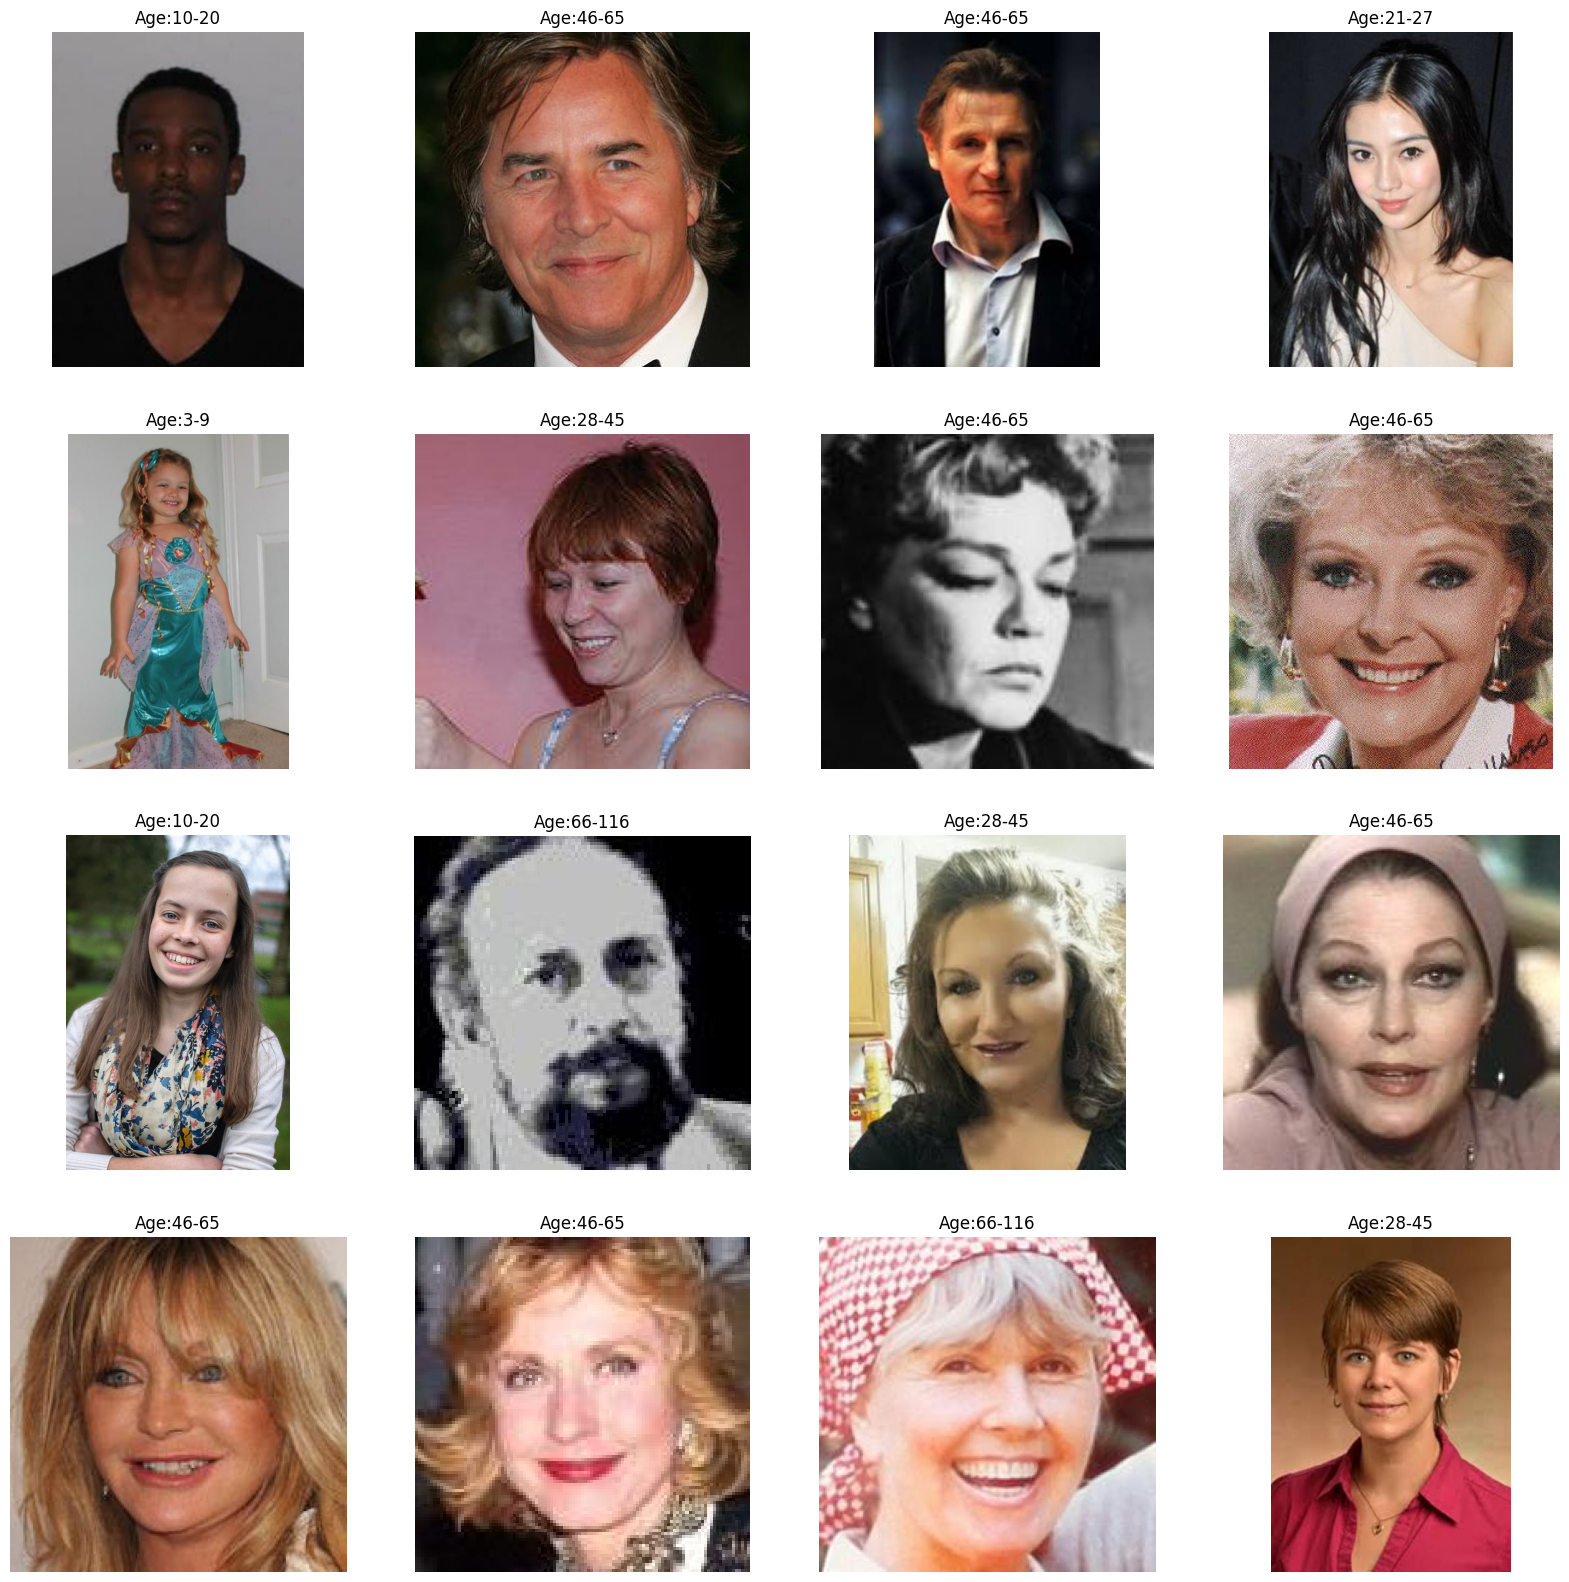

In [12]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

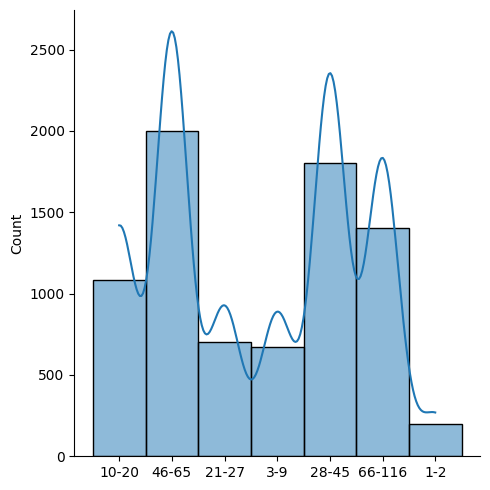

In [13]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [14]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.3, random_state=42)


In [15]:
# Define the model
model = Sequential()

model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))

# Output layer for age range classification (10 ranges)
model.add(Convolution2D(len(age_ranges), (1, 1), activation='relu'))
model.add(Flatten())
model.add(Activation('softmax'))


In [16]:

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/UAGD_VGG-FACE_A3.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [27]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[early_stopping, model_checkpoint], shuffle=False)


Epoch 1/60
138/138 [==============================] - ETA: 0s - loss: 1.9459 - accuracy: 0.0284
Epoch 1: val_accuracy improved from -inf to 0.02275, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/UAGD_VGG-FACE_A3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 55s 399ms/step - loss: 1.9459 - accuracy: 0.0284 - val_loss: 1.9459 - val_accuracy: 0.0227
Epoch 2/60
138/138 [==============================] - ETA: 0s - loss: 1.9459 - accuracy: 0.0284
Epoch 2: val_accuracy did not improve from 0.02275
138/138 [==============================] - 48s 346ms/step - loss: 1.9459 - accuracy: 0.0284 - val_loss: 1.9459 - val_accuracy: 0.0227
Epoch 3/60
138/138 [==============================] - ETA: 0s - loss: 1.9459 - accuracy: 0.0284
Epoch 3: val_accuracy did not improve from 0.02275
138/138 [==============================] - 48s 346ms/step - loss: 1.9459 - accuracy: 0.0284 - val_loss: 1.9459 - val_accuracy: 0.0227
Epoch 4/60
138/138 [==============================] - ETA: 0s - loss: 1.9459 - accuracy: 0.0284
Epoch 4: val_accuracy did not improve from 0.02275
138/138 [==============================] - 48s 346ms/step - loss: 1.9459 - accuracy: 0.0284 - val_loss: 1.9459 - val_accuracy: 0.0227
Epoch 5/60
138/138 [===

In [35]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/UAGD_VGG-FACE_A3.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


74/74 [==============================] - 9s 125ms/step - loss: 1.9459 - accuracy: 0.0212
Test Accuracy: 2.12%


In [36]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

74/74 [==============================] - 9s 124ms/step


In [37]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.02      1.00      0.04        50
           1       0.00      0.00      0.00       188
           2       0.00      0.00      0.00       289
           3       0.00      0.00      0.00       209
           4       0.00      0.00      0.00       581
           5       0.00      0.00      0.00       606
           6       0.00      0.00      0.00       433

    accuracy                           0.02      2356
   macro avg       0.00      0.14      0.01      2356
weighted avg       0.00      0.02      0.00      2356



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.02
Precision: 0.00
Recall: 0.02
F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [33]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 1.00
Accuracy for age range 3-9: 0.00
Accuracy for age range 10-20: 0.00
Accuracy for age range 21-27: 0.00
Accuracy for age range 28-45: 0.00
Accuracy for age range 46-65: 0.00
Accuracy for age range 66-116: 0.00


In [34]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Confusion Matrix:
[[ 50   0   0   0   0   0   0]
 [188   0   0   0   0   0   0]
 [289   0   0   0   0   0   0]
 [209   0   0   0   0   0   0]
 [581   0   0   0   0   0   0]
 [606   0   0   0   0   0   0]
 [433   0   0   0   0   0   0]]
